# Waves
##### A GWDST notebook for managing the huge dataset that is all BTAU parameterized GW outputs for GWDST WACCM run. Check ../scripts/waves.py for most recent analysis!

### Input and data

In [17]:
%matplotlib inline

#from glob import glob
import numpy as np
from scipy.stats import lognorm
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
import seaborn as sns
#import cartopy.crs as ccrs

from dask.distributed import Client

sns.set(context='talk', palette='dark', style='ticks')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46083 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 67.30 GB


Now I will read in and find the magnitude of tau from the individual directions and save it separately to have and to save time!

Let's make sure to read that in now instead of running these calculations. Now, I want to find and compare distributions of the wave fluxes at certain near-tropopause altitudes.

In [3]:
tau = xr.open_dataset('/glade/scratch/mcamron/output/gwdst/tau_magnitude.nc', chunks={'lev': 1, 'time': 24})
tau = tau.sel(lev=slice(70, 130))
tau

<xarray.Dataset>
Dimensions:  (lat: 42, lev: 4, lon: 288, time: 1464, wave: 64)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lev      (lev) float64 73.75 87.82 103.3 121.5
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 -13.66 ...
  * time     (time) datetime64[ns] 2002-06-01 2002-06-01T00:59:59 ...
  * wave     (wave) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    0        (wave, time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

I need to also check a lognormal plot of the same mean and standard deviation as my data. Included!

In [5]:
m = tau['0'].sel(lev=100, method='nearest').mean().values
v = tau['0'].sel(lev=100, method='nearest').var().values
mu = xu.log(m / xu.sqrt(1 + v/m**2))
s = xu.sqrt(xu.log(1 + v/m**2))
scale = xu.exp(mu)

x = np.arange(0, 202, 1)

print(m, v, mu, s, scale)

0.027777308598160744 0.18662825226783752 -6.32981625652 2.34362131218 0.00178236123628


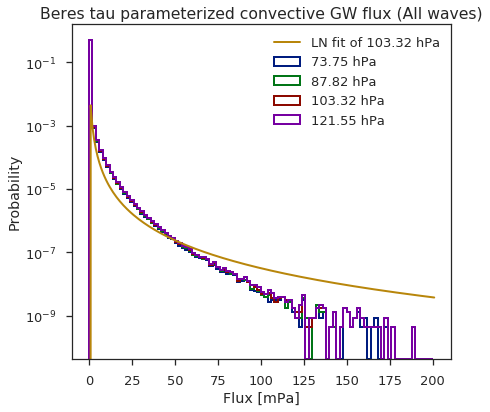

In [18]:
f, ax = plt.subplots(figsize=(7, 6))

for l in tau.lev:
#l = tau.lev.sel(lev=100, method='nearest')
    tau['0'].sel(lev=l).plot.hist(ax=ax, bins=np.arange(0, 201, 2), density=True, log=True, histtype='step', linewidth=2, label=('%.2f hPa' % l.values))

ax.plot(x, lognorm.pdf(x, s, scale=scale), linewidth=2, label=('LN fit of %.2f hPa' % tau.lev.sel(lev=100, method='nearest').values))

ax.legend(loc='upper right')
ax.set_xlabel('Flux [mPa]')
ax.set_ylabel('Probability')
ax.set_title('Beres tau parameterized convective GW flux (All waves)')

plt.tight_layout()

f.savefig('../figures/waves/dist_flux.png')